In [1]:
from bs4 import BeautifulSoup
import time
import requests
import urllib.request
import pandas as pd
import numpy as np
import os
from glob import glob
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from pathlib import Path # for recursive access to folder
from fnmatch import fnmatch
import csv
from functools import reduce
import pytz

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
os.chdir('../')
alt.data_transformers.disable_max_rows()
pd.set_option('display.max_columns', None) 
pd.options.mode.chained_assignment = None

In [4]:
def get_ieso_data(start_year = 2016, end_year = 2019):
    """Scraping ieso data"""
    years = [i for i in range(start_year, end_year + 1)]

    url_base = "http://reports.ieso.ca/public/Demand/"

    urls = []
    for year in years:
        urls.append(url_base + "PUB_Demand_" + str(year) + ".csv")


    r  = requests.get(url_base)
    data = r.text
    soup = BeautifulSoup(data,features="html5lib")

    filenames = []
    for link in soup.find_all('a'):
        if link.get('href').endswith(".csv"):
            filenames.append(url_base+link.get('href'))

    for url in urls:
        assert url in filenames

    column_names = ['date', 'hour', 'market_demand', 'ontario_demand']
    combined_csv = pd.concat([pd.read_csv(url, skiprows=4, names = column_names) for url in urls], ignore_index=True)
    assert len(urls) == len(set(urls)) #Check that there are no duplicate filenames
    
    return combined_csv

In [8]:
def combine_date_time(df):    
    """Combines and converts string date and time as datetime object"""
    return pd.to_datetime(df['date']).combine(pd.to_datetime(df['date']), datetime.time(df['hour']))

def preprocess_ieso_date_time():
    ieso_data = get_ieso_data(2016, 2019)
    ieso_data.date = pd.to_datetime(ieso_data.date)

    ieso_data['hour'] = ieso_data['hour'] - 1

    ieso_data['date_time'] = ieso_data.apply(combine_date_time, axis = 1)


    ieso_data = ieso_data.set_index('date_time')

    ieso_data = ieso_data.drop(columns = ['ontario_demand', 'date', 'hour'])
    
    ieso_data.to_csv("data/cleaned/ieso_data.csv", index=False)
    return ieso_data

ieso_data = preprocess_ieso_date_time()

In [9]:
ieso_data.head()

,market_demand
date_time,
2016-01-01 00:00:00,16767
2016-01-01 01:00:00,16751
2016-01-01 02:00:00,16319
2016-01-01 03:00:00,16148
2016-01-01 04:00:00,16054


In [10]:
ieso_data.describe()

,market_demand
count,35064.000000
mean,17648.880818
std,2173.826219
min,12316.000000
25%,16061.000000
50%,17473.000000
75%,19093.000000
max,25093.000000


In [11]:
ieso_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2016-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   market_demand  35064 non-null  int64
dtypes: int64(1)
memory usage: 547.9 KB


In [12]:
print("Autocorrelation on market demand: {:.3f}".format(ieso_data.market_demand.autocorr()))

Autocorrelation on market demand: 0.965


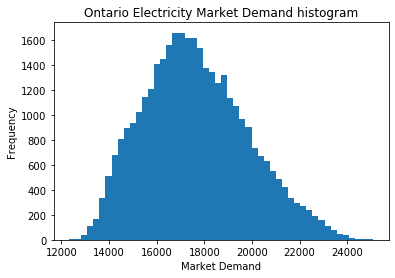

In [14]:
plt.figure()

ieso_data['market_demand'].plot(kind="hist", stacked=True, bins=50)

plt.title("Ontario Electricity Market Demand histogram")
plt.xlabel("Market Demand")
plt.show();

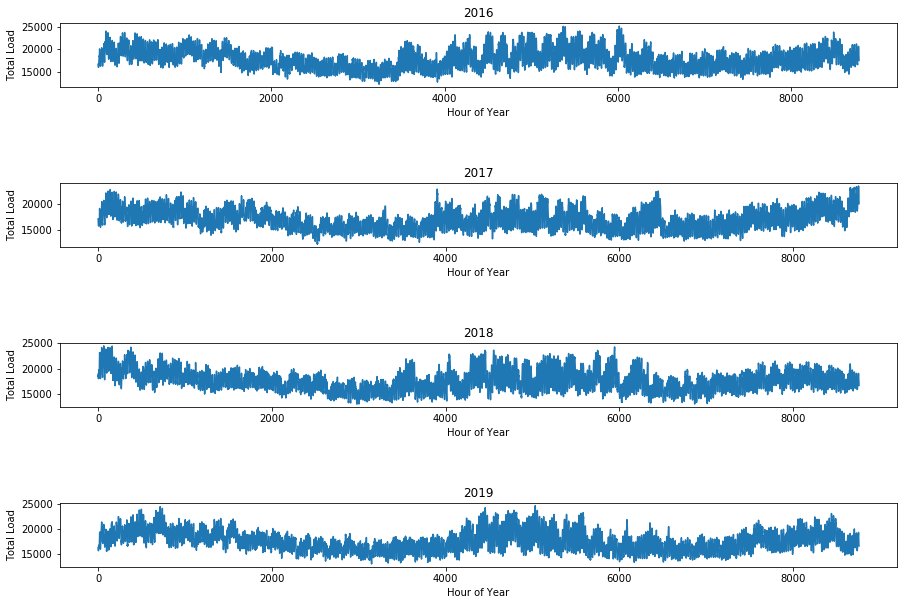

In [16]:
##### Plot the yearly actual loads

#group data by year
groups = ieso_data['market_demand'].groupby(pd.Grouper(freq='A'))

#set figure and axis
fig, axs = plt.subplots(len(groups), 1, figsize=(15,10))


for ax, (name, group) in zip(axs, groups):
    
    #plot the data
    ax.plot(pd.Series(group.values))

    ax.set_xlabel('Hour of Year')
    ax.set_ylabel('Total Load')
    ax.set_title(name.year)
    plt.subplots_adjust(hspace=1.5)

## Station Samples from each Zone
#### Preprocessing for weather data downloading using https://framagit.org/MiguelTremblay/get_canadian_weather_observations/blob/master/README.md

In [80]:
# Fetch Station inventory
def get_station_inventory(province = 'ONTARIO'):
    col_names = ['Name', 'Province', 'Climate ID', 'Station ID', 'WMO ID', 'TC ID', 
                 'Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)', 'Latitude', 
                 'Longitude', 'Elevation (m)', 'First Year', 'Last Year', 'HLY First Year', 
                 'HLY Last Year', 'DLY First Year', 'DLY Last Year', 'MLY First Year', 'MLY Last Year']

    stn = pd.read_csv("https://framagit.org/MiguelTremblay/get_canadian_weather_observations/-/raw/master/station_list/Station%20Inventory%20EN.csv",  
                 skiprows=4, header=None, names=col_names)

    stn = stn[stn['Province'] == province] #Ontario of interest
    return stn


def get_ieso_generation_list():
    gen_list = pd.read_excel('http://www.ieso.ca/-/media/Files/IESO/Document-Library/power-data/supply/IESO-Active-Contracted-Generation-List.xlsx?la=en', 
              skiprows = 2, sheet_name = 'Contract Data')

    gen_list = gen_list.rename(columns = {'Closet City/Town':'Name'})

    gen_list['Name'] = gen_list['Name'].apply(lambda x: str(x).upper())
    return gen_list

def get_top_station_rows():
    top_rows = pd.read_csv("https://framagit.org/MiguelTremblay/get_canadian_weather_observations/-/raw/master/station_list/Station%20Inventory%20EN.csv", 
                           header=None, nrows=3)
    return top_rows


def sample_stations():
    
    station_zone_info = [{'Name':'THUNDER BAY', 'Station_ID': 49389, 'Zone': 'Northwest'},
          {'Name':'LONDON A', 'Station_ID': 50093, 'Zone': 'West'},
          {'Name':'OSHAWA', 'Station_ID': 48649, 'Zone': 'Toronto'},
          {'Name':'KITCHENER/WATERLOO', 'Station_ID': 48569, 'Zone': 'Southwest'},
          {'Name':'OTTAWA INTL A', 'Station_ID': 49568, 'Zone': 'Ottawa'},
          {'Name':'PETERBOROUGH', 'Station_ID': 48952, 'Zone': 'East'},
          {'Name':'MOUNT FOREST (AUT)', 'Station_ID': 7844, 'Zone': 'Bruce'},
          {'Name':'BARRIE-ORO', 'Station_ID': 42183, 'Zone': 'Essa'},
          {'Name':'WELLAND-PELHAM', 'Station_ID': 44283, 'Zone': 'NIAGARA'},
          {'Name':'NORTH BAY A', 'Station_ID': 52318, 'Zone': 'Northeast'}, 
         ]
    sample_zone_df = pd.DataFrame(station_zone_info)
    return sample_zone_df

def preprocess_station_inventory():
    Station_Inventory_EN = get_station_inventory().merge(get_ieso_generation_list(), on='Name', how='inner')
    columns_to_drop = ['Station ID', 'Zone', 'Station_ID']
    
    #Station_Inventory_EN.merge(sample_zone_df, on = 'Name', how = 'inner').drop(columns = columns_to_drop)
    Station_Inventory_EN = stn.merge(sample_stations(), on = 'Name', how='inner').drop(columns = columns_to_drop)
    Station_Inventory_EN[['First Year', 'Last Year', 'HLY First Year', 
                          'HLY Last Year', 'DLY First Year', 
                      'DLY Last Year', 'MLY First Year', 'MLY Last Year']] = Station_Inventory_EN[['First Year', 'Last Year',
                                                                               'HLY First Year', 'HLY Last Year', 'DLY First Year', 'DLY Last Year',
                                                                                'MLY First Year', 'MLY Last Year']].fillna(0).apply(np.int64).replace(0, '')
    return Station_Inventory_EN

#For storing Station_Inventory_EN and downloading weather data
def Save_Station_Inventory_EN():
    top_rows = get_top_station_rows()
    Save_Station_Inventory_EN = preprocess_station_inventory()
    Station_Inventory_EN.to_csv('get_canadian_weather_observations/station_list/Station Inventory EN.csv', index=False)

    with open('get_canadian_weather_observations/station_list/Station Inventory EN.csv', newline='') as f:
        r = csv.reader(f)
        data = [line for line in r]
    with open('get_canadian_weather_observations/station_list/Station Inventory EN.csv','w',newline='') as f:
        w = csv.writer(f)
        w.writerow([top_rows[0][0]])
        w.writerow([top_rows[0][1]])
        w.writerow([top_rows[0][2]])
        w.writerows(data)
    
Save_Station_Inventory_EN()

In [ ]:
# download weather data
# !python get_canadian_weather_observations.py --hourly --start-date 2016-01 --end-date 2019-12 --station-file "/Users/moby/MDS/bluewaveai/get_canadian_weather_observations/station_list/Station Inventory EN.csv" --lang en -o /Users/moby/MDS/bluewaveai/data/new ON

## Weather Data

In [1397]:
# Capturing and encoding all weather conditions as snow, cloud, rain, thunderstorm, fog or clear
def snow(x):
    if 'snow' in x.lower():
        return 1
    return 0

def cloud(x):
    if 'cloud' in x.lower():
        return 1
    return 0


def rain(x):
    if 'rain' in x.lower() or 'drizzle' in x.lower():
        return 1
    return 0

def thunderstorm(x):
    if 'thunderstorm' in x.lower():
        return 1
    return 0

def fog(x):
    if 'fog' in x.lower() or 'haze' in x.lower():
        return 1
    return 0

    
def clear(x):
    if 'clear' in x.lower() or (snow(x) == cloud(x) == rain(x) == thunderstorm(x) == fog(x) == 0):
        return 1
    return 0


In [432]:
t = 'Rain none without CLOUD haze'
# snow(t) == cloud(t) == rain(t) == thunderstorm(t) == fog(t) == 0
print('clear', clear(t))
print('fog', fog(t))
print('thunderstorm', thunderstorm(t))
print('rain', rain(t))
print('cloud', cloud(t))
print('snow', snow(t))

clear 0
fog 1
thunderstorm 0
rain 1
cloud 1
snow 0


In [6]:
# weather_df = pd.read_csv("data/cleaned/weather_df.csv", engine = 'python')

In [1398]:
%%time
working_dir = "data/weather"

all_csv1 = pd.DataFrame()
my_list1 = []
df_count = 1
for root, dirs, files in os.walk(working_dir):
    file_list1 = []
    for filename in files:
        if filename.endswith('.csv'):
            file_list1.append(os.path.join(root, filename)) 
    df_list1 = [pd.read_csv(file) for file in file_list1]
    if df_list1:
        final_df1 = pd.concat(df_list1)
        #Dropping columns with 80% or more missing data
        final_df1 = final_df1[final_df1.columns[final_df1.isnull().mean() < 0.8]]
        try:
            #filling nas
            final_df1['Weather'] = final_df1['Weather'].fillna(method='pad').fillna(method='bfill') #forward fill then backfill for complete elimination of nas
            #Converting Weather/precipitation to string
            final_df1['Weather'] = final_df1['Weather'].astype(str)
            # Create one hot encoding
            final_df1['snow'] = final_df1['Weather'].apply(snow)
            final_df1['cloud'] = final_df1['Weather'].apply(cloud)
            final_df1['rain'] = final_df1['Weather'].apply(rain)
            final_df1['thunderstorm'] = final_df1['Weather'].apply(thunderstorm)
            final_df1['fog'] = final_df1['Weather'].apply(fog)
            final_df1['clear'] = final_df1['Weather'].apply(clear)
        except:
            pass
        # Renaming columns by adding '_' dataframe number
        final_df1.rename(columns={col:'{}_{}'.format(col, df_count) for col in list(set(final_df1.columns) - set(['Date/Time']))}, 
              inplace=True)
        df_count+=1
        my_list1.append(final_df1)

weather_data = reduce(lambda left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), my_list1)

weather_data['date_time'] = pd.to_datetime(weather_data['Date/Time'])
weather_data = weather_data.sort_values(['date_time'])
weather_data = weather_data.set_index('date_time')

#Dropping Year, Month and Day separate columns
weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Year')))] #Drop Year column
weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Month')))] #Drop Month
weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Day')))] #Drop Day columns
weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Climate')))] # Remove Climate Columns
weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Longitude')))] # Drop longitude
weather_data = weather_data[weather_data.columns.drop(list(weather_data.filter(regex='Latitude')))] #Drop latitude
#Saving dataframe as csv
weather_data.to_csv("data/cleaned/weather_df.csv", index=False )

CPU times: user 7.53 s, sys: 1.11 s, total: 8.63 s
Wall time: 11.2 s


Weekdays or not likely have an effect on electricity market demand, so a boolean feature "weekday" is created. Similarly, the time of day certainly has a large impact on electricity consumption. Even though this is a time series problem, in the next section the model in this project is decomposed into two parts. To capture time of day effects in the second part an explicit feature must be created. Since time is a cyclic variable, a sine/cosine transformation is used on the hour the day.

In [1399]:
weather_data['weekday'] = (weather_data.index.weekday < 5).astype(int)
weather_data['sin_hour'] = np.sin(2*np.pi*weather_data.index.hour.values/24)
weather_data['cos_hour'] = np.cos(2*np.pi*weather_data.index.hour.values/24)

In [1598]:
%%time
#Merging weathger and ieso electricity demand data
weather_ieso_df = pd.merge(weather_data, ieso_data, left_index=True, right_index=True)

## Imputation of remaining missing values 
weather_ieso_df = weather_ieso_df.fillna(method='pad').fillna(method='bfill') #backfill and then forward fill for complete elimination of nas

weather_ieso_df = weather_ieso_df.select_dtypes(exclude='object')

CPU times: user 450 ms, sys: 132 ms, total: 582 ms
Wall time: 969 ms


In [1615]:
# weather_ieso_df.to_csv("data/cleaned/working_weather_ieso_df.csv", index=False )

## Dropping One of Highly correlated features

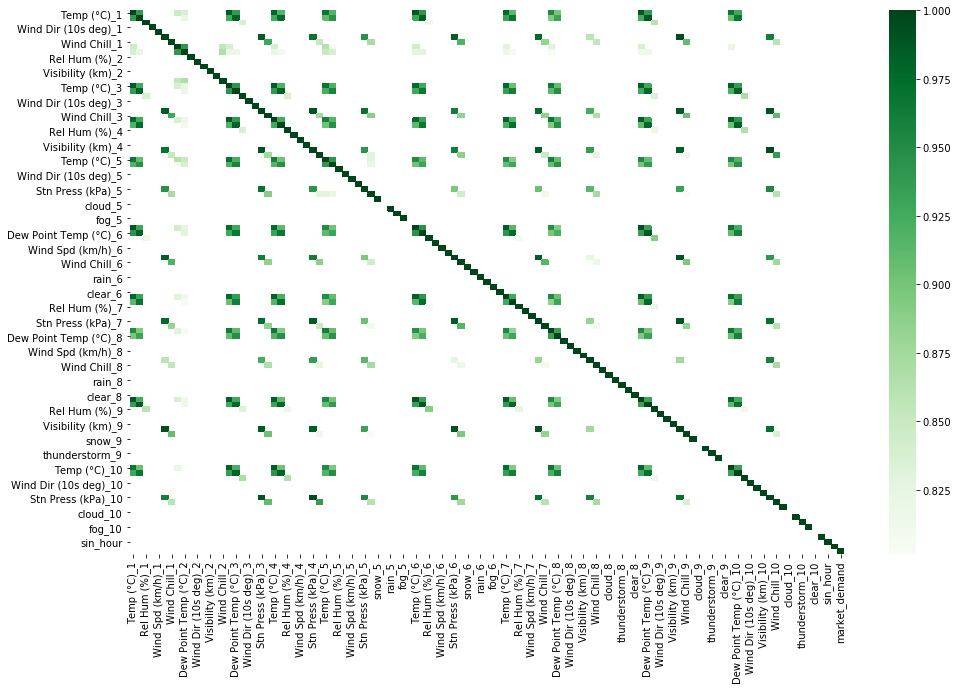

In [1581]:
corr = weather_ieso_df.corr()

kot = corr[corr>=.8]
plt.figure(figsize=(16,10))
sns.heatmap(kot, cmap="Greens")
plt.show()

In [1596]:
def drop_correlated_features(data, corr_threshold):
    col_corr = set() # Contains feature names 
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= corr_threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # Retrieve feature name
                col_corr.add(colname)
                if colname in data.columns:
                    del data[colname] # Remove the feature from the dataset

    return data

def redundant_feature_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def top_abs_correlations(df, n=5):
    feat_corr = df.corr().abs().unstack()
    labels_to_drop = redundant_feature_pairs(df)
    feat_corr = feat_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return feat_corr[0:n]

In [1599]:
top_abs_correlations(weather_ieso_df, 20)

Stn Press (kPa)_4      Stn Press (kPa)_10       0.995848
Stn Press (kPa)_1      Stn Press (kPa)_9        0.994404
Stn Press (kPa)_7      Stn Press (kPa)_9        0.991439
Stn Press (kPa)_6      Stn Press (kPa)_9        0.991055
Stn Press (kPa)_3      Stn Press (kPa)_4        0.991023
Temp (°C)_6            Temp (°C)_9              0.990730
Stn Press (kPa)_3      Stn Press (kPa)_10       0.990287
Dew Point Temp (°C)_1  Dew Point Temp (°C)_9    0.988246
Temp (°C)_1            Temp (°C)_9              0.987910
                       Temp (°C)_6              0.987707
Dew Point Temp (°C)_6  Dew Point Temp (°C)_9    0.987288
Stn Press (kPa)_3      Stn Press (kPa)_9        0.986622
Stn Press (kPa)_6      Stn Press (kPa)_7        0.986615
Stn Press (kPa)_4      Stn Press (kPa)_7        0.986004
Temp (°C)_3            Temp (°C)_4              0.985740
Stn Press (kPa)_1      Stn Press (kPa)_3        0.985213
Temp (°C)_4            Temp (°C)_10             0.985094
Temp (°C)_1            Temp (°C

In [1601]:
##Assign

In [1600]:
weather_ieso_df = drop_correlated_features(data = weather_ieso_df, corr_threshold = 0.8)

In [1602]:
top_abs_correlations(weather_ieso_df, 20)

snow_9             snow_10               0.792035
Wind Chill_1       Wind Chill_2          0.772940
Temp (°C)_1        Wind Chill_1          0.771818
Wind Spd (km/h)_6  Wind Spd (km/h)_9     0.770662
Rel Hum (%)_4      Rel Hum (%)_7         0.769020
Wind Spd (km/h)_1  Wind Spd (km/h)_9     0.756797
Rel Hum (%)_1      Rel Hum (%)_4         0.755818
Wind Spd (km/h)_7  Wind Spd (km/h)_9     0.743504
Wind Spd (km/h)_3  Wind Spd (km/h)_10    0.736142
Wind Spd (km/h)_4  Wind Spd (km/h)_10    0.730090
Rel Hum (%)_1      Rel Hum (%)_7         0.725764
Wind Chill_1       snow_9                0.719064
Wind Spd (km/h)_3  Wind Spd (km/h)_4     0.714962
Wind Chill_1       snow_10               0.709200
Wind Spd (km/h)_1  Wind Spd (km/h)_6     0.708781
Rel Hum (%)_4      Rel Hum (%)_8         0.708605
Rel Hum (%)_5      Rel Hum (%)_8         0.704853
Temp (°C)_1        snow_5                0.703282
                   snow_10               0.691051
                   snow_9                0.689515


In [1597]:
print(weather_ieso_df.shape)
weather_ieso_df.head(3)

(35064, 72)


,Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,snow_5,cloud_5,rain_5,thunderstorm_5,fog_5,clear_5,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,snow_9,cloud_9,rain_9,thunderstorm_9,fog_9,clear_9,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,snow_10,cloud_10,rain_10,thunderstorm_10,fog_10,clear_10,weekday,sin_hour,cos_hour,market_demand
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-2.8,93.0,25.0,15.0,96.67,-8.0,82.0,28.0,11.0,16.1,98.92,-14.0,23.0,12.0,93.0,24.0,8.0,2.8,97.0,17.0,8.0,4.0,1,0,0,0,0,0,26.0,23.0,24.1,1,0,0,0,0,0,68.0,27.0,20.0,91.0,24.0,10.0,24.1,0,0,0,0,0,1,23.0,21.0,16.1,0,0,1,0,0,0,25.0,15.0,8.1,1,0,0,0,0,0,1,0.000000,1.000000,16767
2016-01-01 01:00:00,-2.8,91.0,25.0,16.0,96.61,-8.0,81.0,27.0,13.0,16.1,98.88,-14.0,23.0,13.0,91.0,24.0,11.0,2.4,97.0,20.0,5.0,2.4,1,0,0,0,0,0,26.0,25.0,24.1,0,1,0,0,0,0,67.0,27.0,19.0,90.0,29.0,10.0,6.4,1,0,0,0,0,0,25.0,30.0,14.5,0,0,1,0,0,0,23.0,11.0,6.4,1,0,0,0,0,0,1,0.258819,0.965926,16751
2016-01-01 02:00:00,-3.0,93.0,25.0,20.0,96.56,-9.0,81.0,27.0,15.0,16.1,98.85,-14.0,24.0,14.0,74.0,24.0,18.0,16.1,97.0,24.0,9.0,1.6,1,0,0,0,0,0,25.0,32.0,24.1,1,0,0,0,0,0,70.0,27.0,19.0,92.0,30.0,6.0,4.8,1,0,0,0,0,0,25.0,32.0,16.1,0,0,1,0,0,0,23.0,9.0,4.8,1,0,0,0,0,0,1,0.500000,0.866025,16319


## Lag Feature Selection

In [1585]:
lag_df = pd.DataFrame(weather_ieso_df['market_demand'])
for i in range(1, 169):
    lag_df["T-{}".format(i)] = lag_df["market_demand"].shift(i)

lag_df = lag_df.dropna()

In [1522]:
lag_df.shape

(34896, 169)

In [1534]:
%%time
X = lag_df.drop('market_demand', axis = 1)
y = lag_df['market_demand']
# perform feature selection
rfe = RFE(XGBRegressor(), n_features_to_select=100)
fit = rfe.fit(X, y)

[01:19:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:20:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:21:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:23:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:23:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:24:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [1578]:
ranking_df = pd.DataFrame(rfe.ranking_, names).reset_index()
ranking_df.columns = ('feature', 'ranking')
ranking_df.head(10)

,feature,ranking
0,T-1,1
1,T-2,1
2,T-3,9
3,T-4,1
4,T-5,1
5,T-6,8
6,T-7,1
7,T-8,6
8,T-9,1
9,T-10,1


In [1573]:
# Selected lag features
selected_features = []
names = lag_df.columns.values[1:]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        selected_features.append(names[i])
print("Selected Features")       
print(selected_features)        

Selected Features
['T-1', 'T-2', 'T-4', 'T-5', 'T-7', 'T-9', 'T-10', 'T-11', 'T-12', 'T-13', 'T-14', 'T-15', 'T-16', 'T-18', 'T-19', 'T-20', 'T-21', 'T-22', 'T-23', 'T-24', 'T-25', 'T-26', 'T-27', 'T-28', 'T-29', 'T-30', 'T-31', 'T-32', 'T-33', 'T-34', 'T-35', 'T-36', 'T-38', 'T-40', 'T-43', 'T-45', 'T-50', 'T-53', 'T-54', 'T-56', 'T-57', 'T-58', 'T-59', 'T-67', 'T-68', 'T-69', 'T-70', 'T-71', 'T-74', 'T-76', 'T-77', 'T-78', 'T-80', 'T-81', 'T-82', 'T-83', 'T-86', 'T-91', 'T-95', 'T-96', 'T-98', 'T-99', 'T-101', 'T-102', 'T-105', 'T-106', 'T-107', 'T-113', 'T-114', 'T-116', 'T-118', 'T-119', 'T-120', 'T-122', 'T-126', 'T-133', 'T-138', 'T-139', 'T-140', 'T-141', 'T-142', 'T-143', 'T-145', 'T-146', 'T-147', 'T-148', 'T-149', 'T-150', 'T-151', 'T-153', 'T-154', 'T-155', 'T-157', 'T-159', 'T-160', 'T-164', 'T-165', 'T-166', 'T-167', 'T-168']


## Assigning Lag Variables to the original data

In [1604]:
for i in range(1, 169):
    if "T-{}".format(i) in selected_features:
#         print("T-{}".format(i))
        weather_ieso_df["T-{}".format(i)] = weather_ieso_df["market_demand"].shift(i)

In [1605]:
weather_ieso_df

,Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,snow_5,cloud_5,rain_5,thunderstorm_5,fog_5,clear_5,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,snow_9,cloud_9,rain_9,thunderstorm_9,fog_9,clear_9,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,snow_10,cloud_10,rain_10,thunderstorm_10,fog_10,clear_10,weekday,sin_hour,cos_hour,market_demand,T-1,T-2,T-4,T-5,T-7,T-9,T-10,T-11,T-12,T-13,T-14,T-15,T-16,T-18,T-19,T-20,T-21,T-22,T-23,T-24,T-25,T-26,T-27,T-28,T-29,T-30,T-31,T-32,T-33,T-34,T-35,T-36,T-38,T-40,T-43,T-45,T-50,T-53,T-54,T-56,T-57,T-58,T-59,T-67,T-68,T-69,T-70,T-71,T-74,T-76,T-77,T-78,T-80,T-81,T-82,T-83,T-86,T-91,T-95,T-96,T-98,T-99,T-101,T-102,T-105,T-106,T-107,T-113,T-114,T-116,T-118,T-119,T-120,T-122,T-126,T-133,T-138,T-139,T-140,T-141,T-142,T-143,T-145,T-146,T-147,T-148,T-149,T-150,T-151,T-153,T-154,T-155,T-157,T-159,T-160,T-164,T-165,T-166,T-167,T-168
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-2.8,93.0,25.0,15.0,96.67,-8.0,82.0,28.0,11.0,16.1,98.92,-14.0,23.0,12.0,93.0,24.0,8.0,2.8,97.0,17.0,8.0,4.0,1,0,0,0,0,0,26.0,23.0,24.1,1,0,0,0,0,0,68.0,27.0,20.0,91.0,24.0,10.0,24.1,0,0,0,0,0,1,23.0,21.0,16.1,0,0,1,0,0,0,25.0,15.0,8.1,1,0,0,0,0,0,1,0.000000,1.000000,16767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,-2.8,91.0,25.0,16.0,96.61,-8.0,81.0,27.0,13.0,16.1,98.88,-14.0,23.0,13.0,91.0,24.0,11.0,2.4,97.0,20.0,5.0,2.4,1,0,0,0,0,0,26.0,25.0,24.1,0,1,0,0,0,0,67.0,27.0,19.0,90.0,29.0,10.0,6.4,1,0,0,0,0,0,25.0,30.0,14.5,0,0,1,0,0,0,23.0,11.0,6.4,1,0,0,0,0,0,1,0.258819,0.965926,16751,16767.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,-3.0,93.0,25.0,20.0,96.56,-9.0,81.0,27.0,15.0,16.1,98.85,-14.0,24.0,14.0,74.0,24.0,18.0,16.1,97.0,24.0,9.0,1.6,1,0,0,0,0,0,25.0,32.0,24.1,1,0,0,0,0,0,70.0,27.0,19.0,92.0,30.0,6.0,4.8,1,0,0,0,0,0,25.0,32.0,16.1,0,0,1,0,0,0,23.0,9.0,4.8,1,0,0,0,0,0,1,0.500000,0.866025,16319,16751.0,16767.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,-3.0,87.0,25.0,17.0,96.58,-9.0,80.0,27.0,17.0,16.1,98.81,-15.0,26.0,17.0,73.0,23.0,17.0,16.1,97.0,25.0,13.0,6.4,1,0,0,0,0,0,26.0,19.0,24.1,1,0,0,0,0,0,74.0,27.0,19.0,94.0,24.0,5.0,4.8,1,0,0,0,0,

In [1607]:
##How to handle na

weather_ieso_df = weather_ieso_df.dropna().head()

,Temp (°C)_1,Rel Hum (%)_1,Wind Dir (10s deg)_1,Wind Spd (km/h)_1,Stn Press (kPa)_1,Wind Chill_1,Rel Hum (%)_2,Wind Dir (10s deg)_2,Wind Spd (km/h)_2,Visibility (km)_2,Stn Press (kPa)_2,Wind Chill_2,Wind Dir (10s deg)_3,Wind Spd (km/h)_3,Rel Hum (%)_4,Wind Dir (10s deg)_4,Wind Spd (km/h)_4,Visibility (km)_4,Rel Hum (%)_5,Wind Dir (10s deg)_5,Wind Spd (km/h)_5,Visibility (km)_5,snow_5,cloud_5,rain_5,thunderstorm_5,fog_5,clear_5,Wind Dir (10s deg)_6,Wind Spd (km/h)_6,Visibility (km)_6,snow_6,cloud_6,rain_6,thunderstorm_6,fog_6,clear_6,Rel Hum (%)_7,Wind Dir (10s deg)_7,Wind Spd (km/h)_7,Rel Hum (%)_8,Wind Dir (10s deg)_8,Wind Spd (km/h)_8,Visibility (km)_8,snow_8,cloud_8,rain_8,thunderstorm_8,fog_8,clear_8,Wind Dir (10s deg)_9,Wind Spd (km/h)_9,Visibility (km)_9,snow_9,cloud_9,rain_9,thunderstorm_9,fog_9,clear_9,Wind Dir (10s deg)_10,Wind Spd (km/h)_10,Visibility (km)_10,snow_10,cloud_10,rain_10,thunderstorm_10,fog_10,clear_10,weekday,sin_hour,cos_hour,market_demand,T-1,T-2,T-4,T-5,T-7,T-9,T-10,T-11,T-12,T-13,T-14,T-15,T-16,T-18,T-19,T-20,T-21,T-22,T-23,T-24,T-25,T-26,T-27,T-28,T-29,T-30,T-31,T-32,T-33,T-34,T-35,T-36,T-38,T-40,T-43,T-45,T-50,T-53,T-54,T-56,T-57,T-58,T-59,T-67,T-68,T-69,T-70,T-71,T-74,T-76,T-77,T-78,T-80,T-81,T-82,T-83,T-86,T-91,T-95,T-96,T-98,T-99,T-101,T-102,T-105,T-106,T-107,T-113,T-114,T-116,T-118,T-119,T-120,T-122,T-126,T-133,T-138,T-139,T-140,T-141,T-142,T-143,T-145,T-146,T-147,T-148,T-149,T-150,T-151,T-153,T-154,T-155,T-157,T-159,T-160,T-164,T-165,T-166,T-167,T-168
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-08 00:00:00,-0.6,80.0,14.0,5.0,97.02,-2.0,96.0,8.0,18.0,16.1,99.03,-6.0,0.0,0.0,94.0,3.0,9.0,4.8,85.0,13.0,9.0,16.1,1,0,0,0,0,0,8.0,12.0,24.1,0,1,0,0,0,0,89.0,5.0,3.0,88.0,3.0,8.0,24.1,0,1,0,0,0,0,7.0,4.0,11.3,0,0,0,0,1,0,28.0,4.0,4.8,0,0,0,0,1,0,1,0.000000,1.000000,17846,18367.0,19625.0,21576.0,21940.0,21801.0,20342.0,20161.0,19922.0,20063.0,20337.0,20463.0,20476.0,20873.0,19402.0,18298.0,17561.0,17330.0,17506.0,17477.0,17925.0,18766.0,20030.0,20966.0,21468.0,22086.0,22286.0,22628.0,21450.0,20416.0,20289.0,20216.0,19796.0,20417.0,21583.0,18240.0,17944.0,20463.0,23262.0,23629.0,22494.0,21220.0,20746.0,20761.0,20075.0,18859.0,18882.0,19015.0,19071.0,21205.0,23028.0,23102.0,23703.0,22939.0,21706.0,21192.0,21146.0,21213.0,18269.0,17629.0,17965.0,19138.0,19909.0,21009.0,21258.0,18645.0,18463.0,18524.0,17351.0,16929.0,16319.0,16499.0,16592.0,17408.0,18312.0,20289.0,18835.0,16962.0,16481.0,16479.0,16312.0,16564.0,16789.0,17442.0,17782.0,18814.0,19137.0,19554.0,19972.0,20100.0,18374.0,18373.0,18586.0,17943.0,17066.0,16688.0,16054.0,16148.0,16319.0,16751.0,16767.0
2016-01-08 01:00:00,-1.8,88.0,16.0,6.0,96.98,-4.0,98.0,7.0,11.0,8.1,98.98,-5.0,1.0,3.0,93.0,6.0,5.0,6.4,87.0,12.0,8.0,16.1,1,0,0,0,0,0,8.0,10.0,24.1,0,0,0,0,0,1,91.0,11.0,5.0,92.0,3.0,13.0,24.1,0,0,0,0,0,1,7.0,9.0,4.0,0,0,0,0,1,0,28.0,0.0,6.4,0,0,0,0,1,0,1,0.258819,0.965926,17379,17846.0,18367.0,20690.0,21576.0,21920.0,20893.0,20342.0,20161.0,19922.0,20063.0,20337.0,20463.0,20476.0,20710.0,19402.0,18298.0,17561.0,17330.0,17506.0,17477.0,17925.0,18766.0,20030.0,20966.0,21468.0,22086.0,22286.0,22628.0,21450.0,20416.0,20289.0,20216.0,20044.0,20947.0,19457.0,17898.0,18834.0,22462.0,23262.0,23364.0,22494.0,21220.0,20746.0,21834.0,20075.0,18859.0,18882.0,19015.0,19817.0,22404.0,23028.0,23102.0,24010.0,22939.0,21706.0,21192.0,21218.0,19542.0,17406.0,17629.0,18275.0,19138.0,20191.0,21009.0,19743.0,18645.0,18463.0,17314.0,17351.0,16512.0,16362.0,16499.0,16592.0,17878.0,19972.0,18853.0,17143.0,16962.0,16481.0,16479.0,16312.0,16564.0,17064.0,17442.0,17782.0,18814.0,19137.0,19554.0,19972.0,18963.0,18374.0,18373.0,18289.0,17598.0,17066.0,16100.0,16054.0,16148.0,16319.0,16751.0
2016-01-08 02:00:00,-2.4,91.0,14.0,3.0,96.96,-4.0,99.0,4.0,5.0,8.1,98.92,-2.0,0.0,1.0,90.0,9.0,5.0,12.9,85.0,13.0,8.0,16.1,1,0,0,0,0,0,8.0,13.0,2

## Handling Daylight Saving

In [1609]:
def is_dst(dt=None, timezone="UTC"):
    if dt is None:
        dt = datetime.utcnow()
    timezone = pytz.timezone(timezone)
    timezone_aware_date = timezone.localize(dt, is_dst=False)
    return timezone_aware_date.tzinfo._dst.seconds != 0

dst_df = weather_ieso_df.index.to_series().apply(is_dst, timezone="America/Toronto").astype('uint8')

In [1616]:
weather_ieso_df.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2019-12-31 14:00:00', '2019-12-31 15:00:00',
               '2019-12-31 16:00:00', '2019-12-31 17:00:00',
               '2019-12-31 18:00:00', '2019-12-31 19:00:00',
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=35064, freq=None)

In [1613]:
dst_df[dst_df.values == 1]

date_time
2016-03-13 02:00:00    1
2016-03-13 03:00:00    1
2016-03-13 04:00:00    1
2016-03-13 05:00:00    1
2016-03-13 06:00:00    1
                      ..
2019-11-02 21:00:00    1
2019-11-02 22:00:00    1
2019-11-02 23:00:00    1
2019-11-03 00:00:00    1
2019-11-03 01:00:00    1
Name: date_time, Length: 22848, dtype: uint8

In [1614]:
dst_df[dst_df.values == 0]

date_time
2016-01-01 00:00:00    0
2016-01-01 01:00:00    0
2016-01-01 02:00:00    0
2016-01-01 03:00:00    0
2016-01-01 04:00:00    0
                      ..
2019-12-31 19:00:00    0
2019-12-31 20:00:00    0
2019-12-31 21:00:00    0
2019-12-31 22:00:00    0
2019-12-31 23:00:00    0
Name: date_time, Length: 12216, dtype: uint8

In [ ]:
# %%time
# #use linear regression as the model
# lr = LinearRegression()
# #rank all features, i.e continue the elimination until the last one
# rfe = RFE(lr, n_features_to_select=)
# rfe.fit(X,y)
to_series().apply(is_dst, timezone="America/Toronto")

In [1570]:
# sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))

## Monthly and Weekly Averages

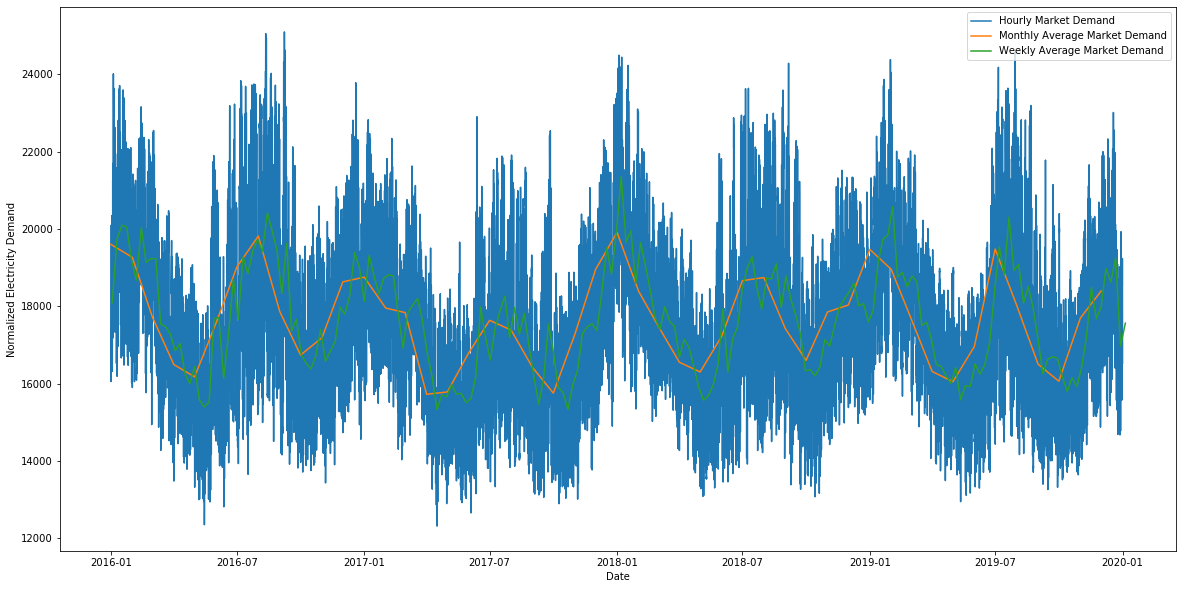

In [1480]:
monthly_data = weather_ieso_df['market_demand'].resample('MS').mean()
weekly_data = weather_ieso_df['market_demand'].resample('W').mean()
plt.figure(figsize=(20,10))
plt.plot(weather_ieso_df['market_demand'], label='Hourly Market Demand')
plt.plot(monthly_norm, label='Monthly Average Market Demand')
plt.plot(weekly_data, label='Weekly Average Market Demand')
plt.ylabel('Normalized Electricity Demand')
plt.xlabel('Date')
plt.legend(loc='upper right');

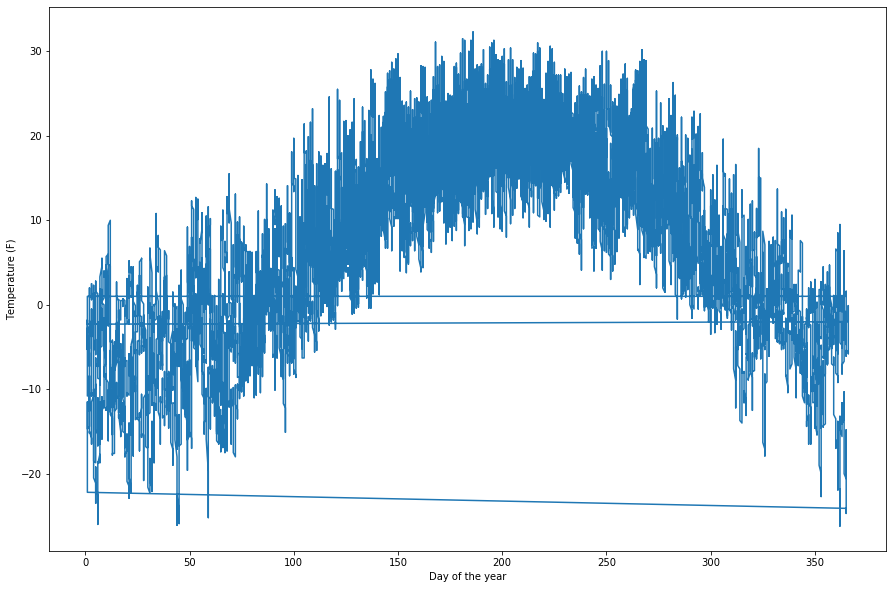

In [1481]:
plt.figure(figsize=(15, 10))
plt.plot(weather_ieso_df.index.dayofyear, weather_ieso_df['Temp (°C)_1'])
plt.xlabel('Day of the year')
plt.ylabel('Temperature (F)')
plt.show();

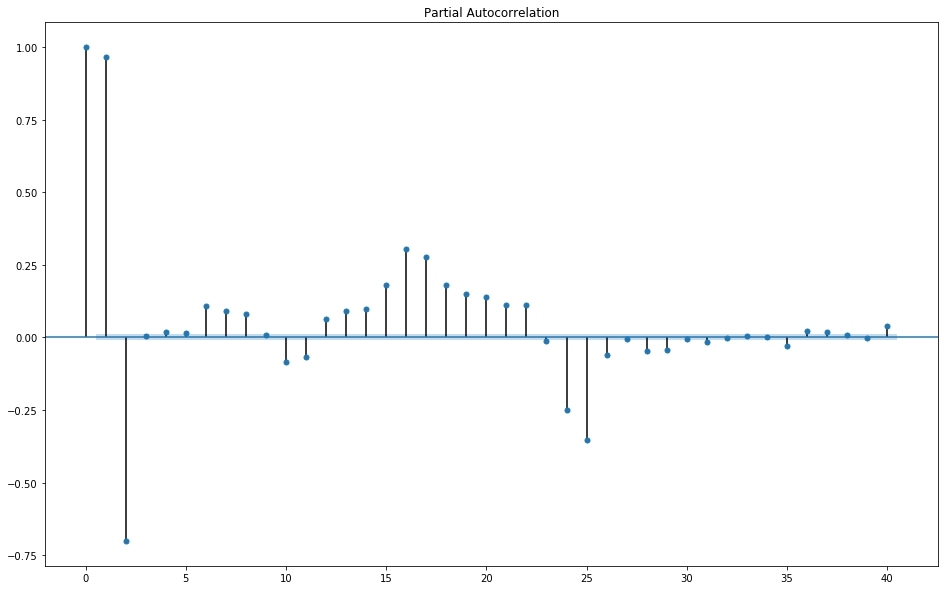

In [1482]:
fig = tsaplots.plot_pacf(weather_ieso_df.market_demand, lags=40) 
plt.show()

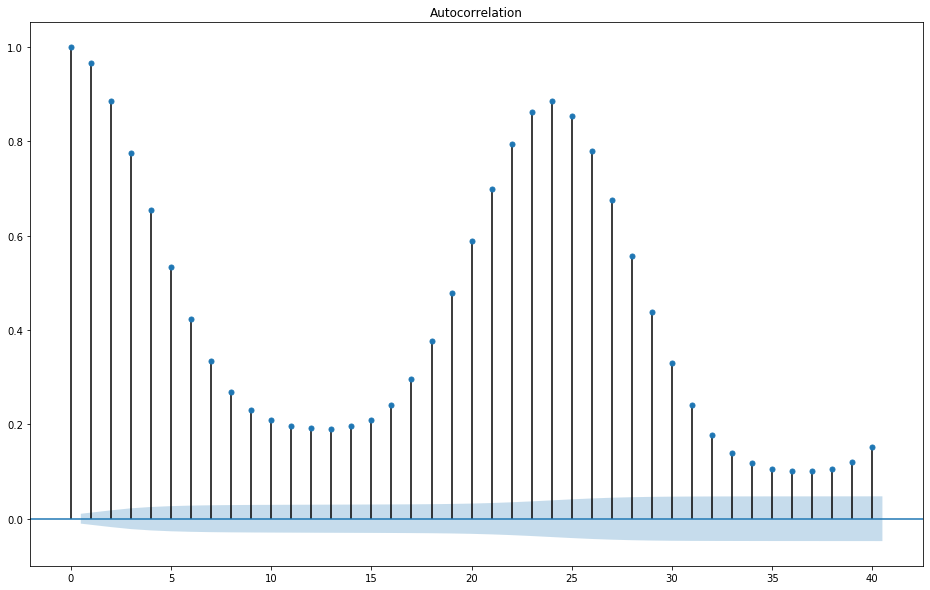

In [1483]:
fig = tsaplots.plot_acf(weather_ieso_df.market_demand, lags=40) 
plt.show()

## Subtracting the monthly average

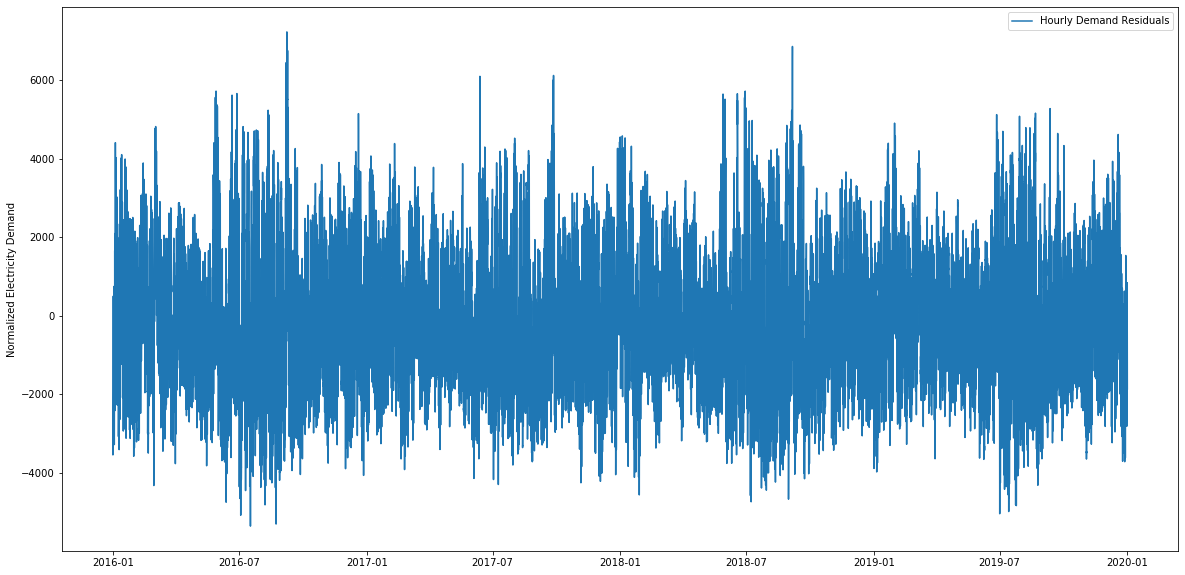

In [1484]:
#Using hourly residuals by subtracting MA from each demand
weather_ieso_df['market_demand'] = weather_ieso_df['market_demand'].groupby(pd.Grouper(freq='M')).transform(lambda x: x - x.mean())
plt.figure(figsize=(20,10))
plt.plot(weather_ieso_df['market_demand'], label='Hourly Demand Residuals')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

## Shift

In [1485]:
def shift_df(df, col_name):
    """
    Using previous market demand to predict the next
    """
    df['shift_demand'] = df[col_name].shift().bfill().values[:,None]
    return df

## Splitting revisit scikit train_test_split

In [1486]:
def split_data(df):
    
    train_df = weather_ieso_df[:'2017']
    #Shit
    train_df = shift_df(train_df, 'market_demand')
    
    val_df = weather_ieso_df['2018']
    #Shift
    val_df = shift_df(val_df, 'market_demand')
    
    test_df = weather_ieso_df['2019']
    #Shift
    test_df = shift_df(test_df, 'market_demand')

    X_train = train_df.drop('market_demand', axis = 1) 
    X_valid = val_df.drop('market_demand', axis = 1) 
    X_test = test_df.drop('market_demand', axis = 1)
    
    y_train = train_df['market_demand']
    y_valid = val_df['market_demand']
    y_test = test_df['market_demand']
    
    print('X_train Shape: ', X_train.shape)
    print('X_validation Shape: ', X_valid.shape)
    print('X_test Shape: ', X_test.shape)
    print('y_train Shape: ', y_train.shape)
    print('y_test Shape: ', y_test.shape)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(weather_ieso_df)

X_train Shape:  (17544, 72)
X_validation Shape:  (8760, 72)
X_test Shape:  (8760, 72)
y_train Shape:  (17544,)
y_test Shape:  (8760,)


## Standard Scaling

In [1487]:
def scaler_X_y(X_train, X_valid, X_test, y_train, y_valid, y_test):
    exclude_columns = ['weekday', 'sin_hour', 'cos_hour', 'market_demand', 'shift_demand']
    exclude_columns.extend([col for col in X_train if col.startswith('snow')])
    exclude_columns.extend([col for col in X_train if col.startswith('cloud')])
    exclude_columns.extend([col for col in X_train if col.startswith('rain')])
    exclude_columns.extend([col for col in X_train if col.startswith('thunderstorm')])
    exclude_columns.extend([col for col in X_train if col.startswith('fog')])
    exclude_columns.extend([col for col in X_train if col.startswith('clear')])

    numeric_features = list(set(X_train.columns)-set(exclude_columns))

    #Scaling
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_train[numeric_features] = scaler_X.fit_transform(X_train[numeric_features])
    X_valid[numeric_features] = scaler_X.transform(X_valid[numeric_features])
    X_test[numeric_features] = scaler_X.transform(X_test[numeric_features])

    y_train = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))
    y_valid = scaler_y.transform(np.array(y_valid).reshape(-1, 1))
    y_test = scaler_y.transform(np.array(y_test).reshape(-1, 1))
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, scaler_X, scaler_y

X_train_unscaled, X_valid_unscaled, X_test_unscaled, \
y_train_unscaled, y_valid_unscaled, y_test_unscaled = X_train.copy(), X_valid.copy(), X_test.copy(), y_train.copy(), y_valid.copy(), y_test.copy()

X_train, X_valid, X_test, y_train, y_valid, y_test, scaler_X, scaler_y = scaler_X_y(X_train, X_valid, X_test, y_train, y_valid, y_test)

In [1488]:
X_train.shape

(17544, 72)

In [1489]:
X_test.shape

(8760, 72)

In [871]:
# def compute_mae(y, y_hat):
#     """given predicted and observed values, computes mean absolute error"""
#     return np.mean(np.abs(y_hat - y))


## Models

In [1411]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates mean absolute percentage error given original label and predicted label"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [1412]:
def plot_pred(y, yhat, yhat_idx):
    """plots observed and forecasted values for the full date range"""
    pred = pd.Series(yhat, index=yhat_idx)
    indexed_y = pd.Series(y, index=yhat_idx)
    plt.figure(figsize=(20,10))
    plt.plot(indexed_y, label='Observed')
    plt.plot(pred, label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()

#### Linear Regression

In [1413]:
# train model and get predictions
# Linear Regression

lr_model = LinearRegression()
lr_model.fit(X_train.values, y_train);

In [1422]:
lr_pred = lr_model.predict(X_valid.values)
# lr_pred = scaler_y.inverse_transform(lr_pred)

MAE: 362.69891099248457
MAPE: 110.71932254293506


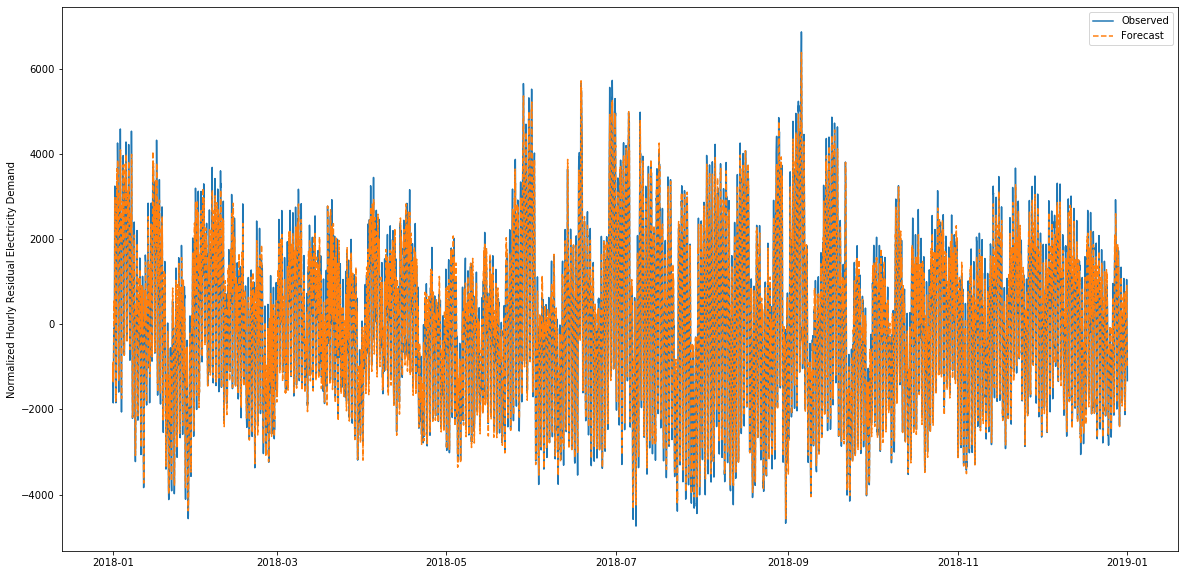

In [1423]:
print('MAE:', mean_absolute_error(scaler_y.inverse_transform(y_valid), scaler_y.inverse_transform(lr_pred.reshape(-1, 1))))
print('MAPE:', mean_absolute_percentage_error(scaler_y.inverse_transform(y_valid), scaler_y.inverse_transform(lr_pred.reshape(-1, 1))))

plot_pred(scaler_y.inverse_transform(y_valid).ravel(), scaler_y.inverse_transform(lr_pred.reshape(-1, 1)).ravel(), y_valid_unscaled.index)

In [1200]:
# plot_pred(y_valid.ravel(), lr_pred.ravel(), y_valid_unscaled.index)
# print("MAE:", mean_absolute_error(y_valid, lr_pred))
# print("MAPE", mean_absolute_percentage_error(y_valid, lr_pred))

#### Gradient Boosting Regressor

In [1158]:
%%time
gbr = GradientBoostingRegressor()
gbr_parameters = {'learning_rate': [.01, 0.1, 1], 
              'max_depth': [2, 4, 6],
              'n_estimators': [200, 500, 1000]}

gbr_grid = GridSearchCV(gbr,
                        gbr_parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

gbr_grid.fit(X_train,
         y_train.ravel())

print(gbr_grid.best_score_)
print(gbr_grid.best_params_)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 14.6min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed: 19.2min finished


0.9736996146512114
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
CPU times: user 3min 47s, sys: 701 ms, total: 3min 47s
Wall time: 23min


MAE: 234.7307782082707
MAPE: 80.52087134997534


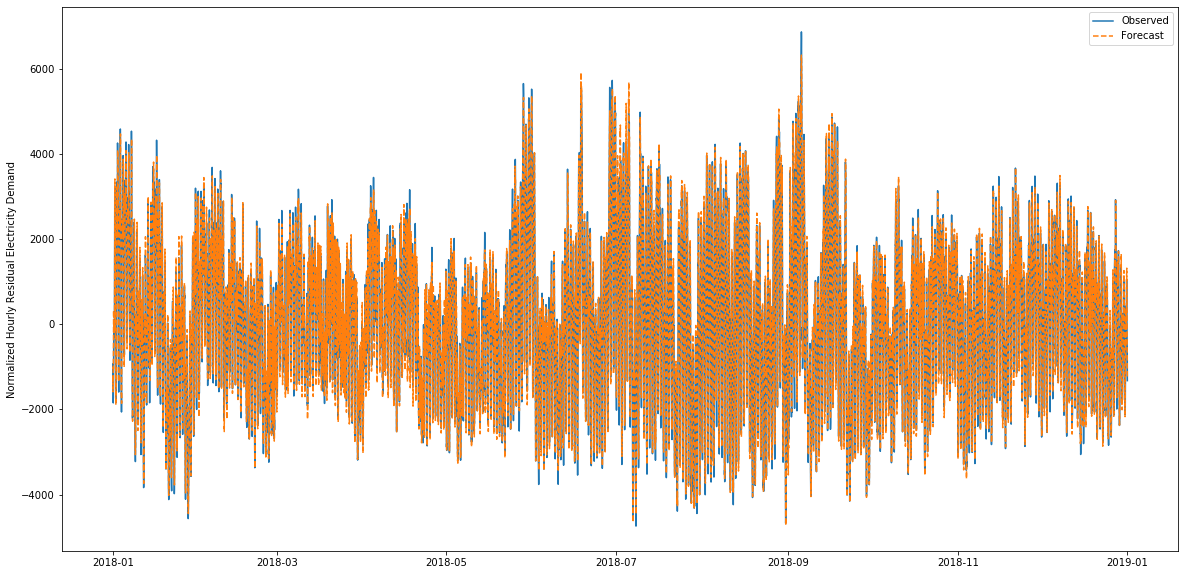

In [1193]:
# Optimal hyperparamters
y_pred_gbr = gbr_grid.predict(X_valid.values)

# compute error, and plot on both long and short time scales
print('MAE:', mean_absolute_error(scaler_y.inverse_transform(y_valid), scaler_y.inverse_transform(y_pred_gbr.reshape(-1, 1))))
print('MAPE:', mean_absolute_percentage_error(scaler_y.inverse_transform(y_valid), scaler_y.inverse_transform(y_pred_gbr.reshape(-1, 1))))

# plot_pred(y_valid.ravel(), y_pred_gbr.ravel(), y_valid_unscaled.index)

plot_pred(scaler_y.inverse_transform(y_valid).ravel(), scaler_y.inverse_transform(y_pred_gbr.reshape(-1, 1)).ravel(), y_valid_unscaled.index)

#### XGBRegressor

In [1161]:
%%time
# Various hyper-parameters to tune
xgb = XGBRegressor()
parameters = {'learning_rate': [.01, 0.1, 1], 
              'max_depth': [2, 4, 6],
              'n_estimators': [200, 500, 1000]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train.ravel())

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 10.0min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed: 12.8min finished


[23:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9737612591911715
{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
CPU times: user 2min 54s, sys: 1.41 s, total: 2min 56s
Wall time: 15min 51s


MAE: 227.03972383260682
MAPE: 80.98133091922391


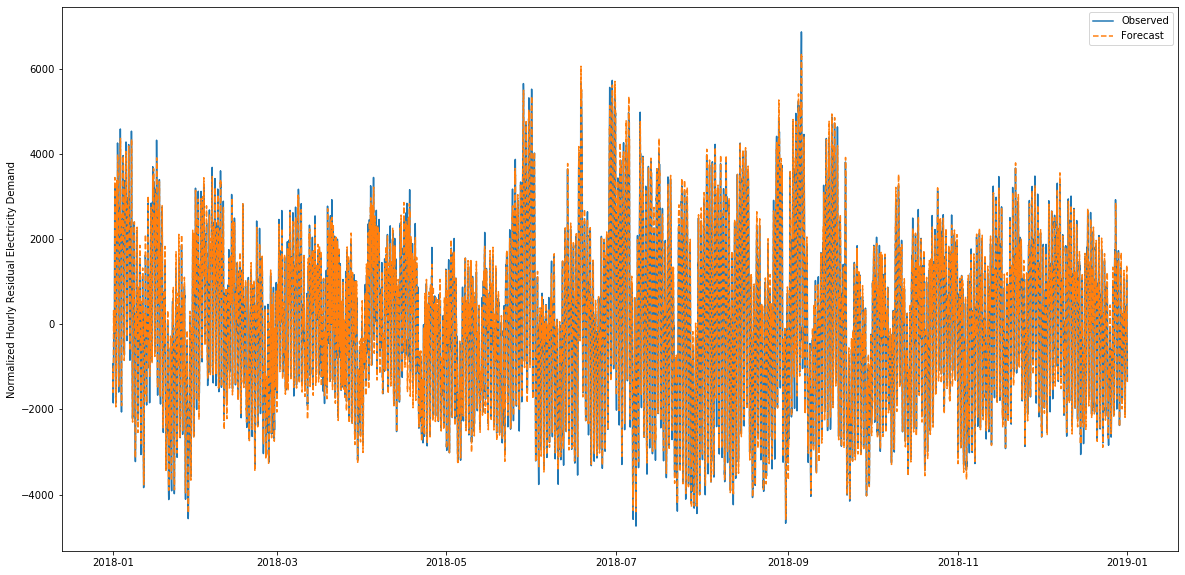

In [1198]:
y_pred_xgb = xgb_grid.predict(X_valid)

# compute error, and plot 
# print('MAE:', mean_absolute_error(y_valid, y_pred_gbr))
# print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred_gbr))
print('MAE:', mean_absolute_error(scaler_y.inverse_transform(y_valid), scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1))))
print('MAPE:', mean_absolute_percentage_error(scaler_y.inverse_transform(y_valid), scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1))))


# plot_pred(y_valid.ravel(), y_pred_gbr.ravel(), y_valid_unscaled.index)

plot_pred(scaler_y.inverse_transform(y_valid).ravel(), scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).ravel(), y_valid_unscaled.index)

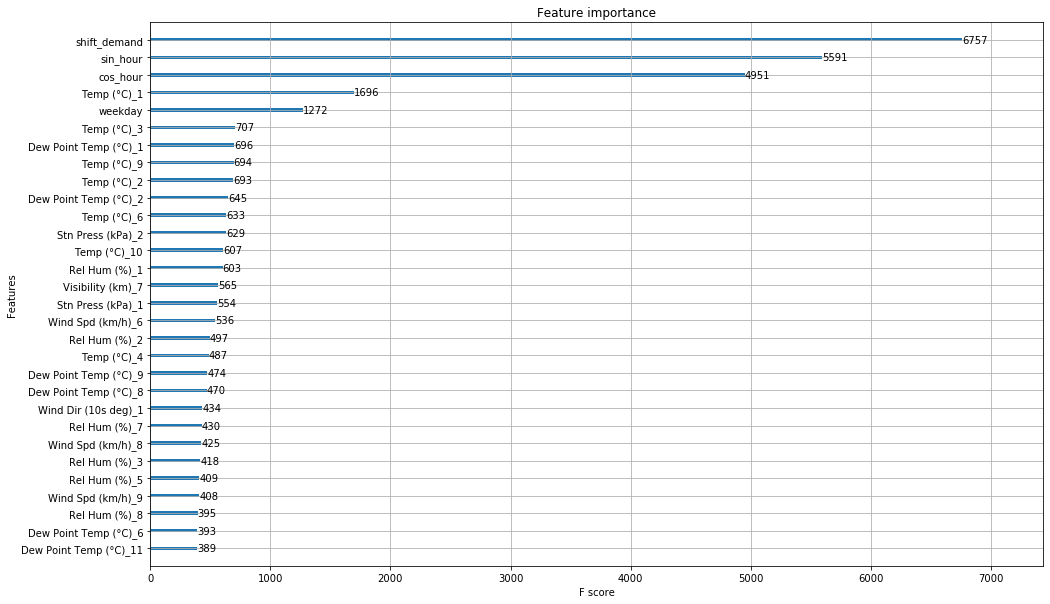

In [1197]:
#Top 30 important features
plt.rcParams["figure.figsize"] = (16, 10)
plot_importance(xgb_grid.best_estimator_, max_num_features=30)
plt.show()

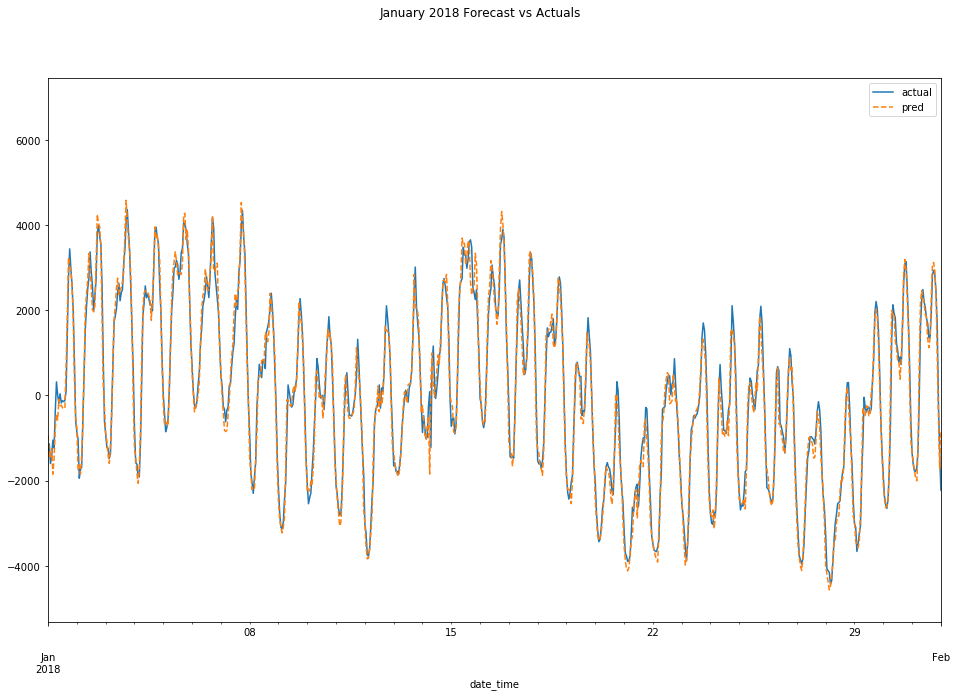

In [1226]:
df22 = pd.DataFrame(scaler_y.inverse_transform(y_valid).ravel(), scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).ravel()).reset_index()
df22.index=y_valid_unscaled.index
df22.columns = ('actual', 'pred')

f, ax = plt.subplots(1)
_ = df22.plot(ax=ax,style=['-','--'])
ax.set_xbound(lower='01-01-2018', upper='02-01-2018')
plot = plt.suptitle('January 2018 Forecast vs Actuals')

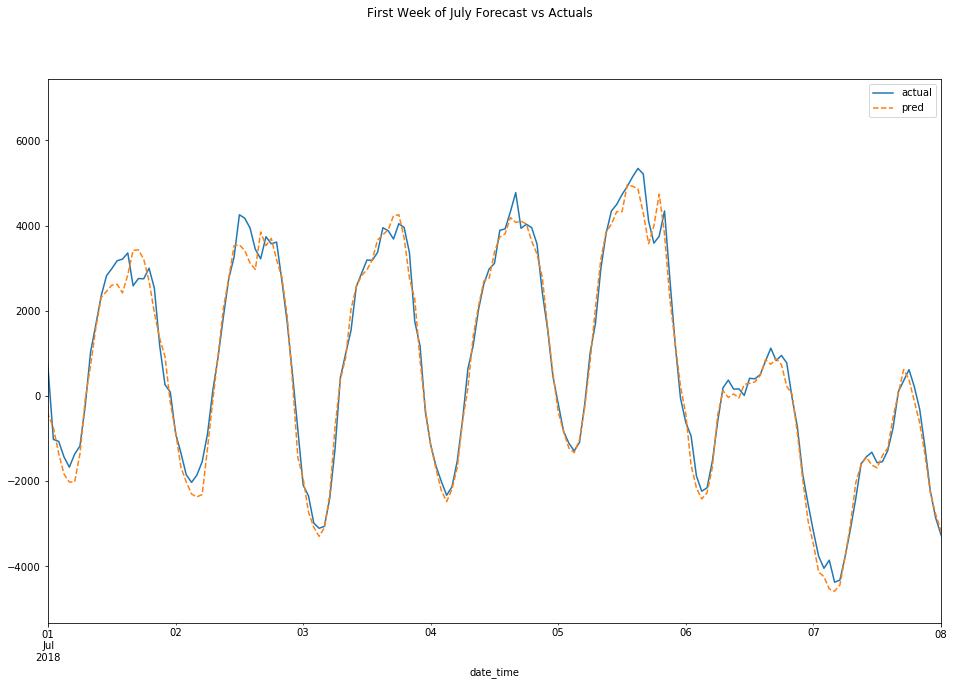

In [1227]:
f, ax = plt.subplots(1)
_ = df22.plot(ax=ax,style=['-','--'])
ax.set_xbound(lower='07-01-2018', upper='07-08-2018')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Worst Predictions

In [1292]:
df_worst = pd.DataFrame(scaler_y.inverse_transform(y_valid).ravel() - scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).ravel()).reset_index(drop=True)
df_worst.columns = (['error'])
df_worst['actual'] = scaler_y.inverse_transform(y_valid).ravel()
df_worst['preds'] = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).ravel()
df_worst['abs_error'] = np.abs(df_worst.error)
df_worst.index = X_valid.index
df_worst


,error,actual,preds,abs_error
date_time,,,,
2018-01-01 00:00:00,347.605551,-935.540323,-1283.145874,347.605551
2018-01-01 01:00:00,-328.934366,-1462.540323,-1133.605957,328.934366
2018-01-01 02:00:00,143.795371,-1456.540323,-1600.335693,143.795371
2018-01-01 03:00:00,186.280722,-1247.540323,-1433.821045,186.280722
2018-01-01 04:00:00,-801.541543,-1849.540323,-1047.998779,801.541543
...,...,...,...,...
2018-12-31 19:00:00,-389.060360,244.940860,634.001221,389.060360
2018-12-31 20:00:00,63.164672,14.940860,-48.223812,63.164672
2018-12-31 21:00:00,167.344364,-515.059140,-682.403503,167.344364


In [1293]:
X_valid_df = pd.concat([X_valid, df_worst],axis=1)
error_by_day = X_valid_df.groupby([X_valid_df.index.year, X_valid_df.index.month,\
                                   X_valid_df.index.strftime("%d")]).mean()[['error', 'actual', 'preds', 'abs_error']]

error_by_day.sort_values('error', ascending=True).head(10)

error       actual        preds  \
date_time date_time date_time                                         
2018      7         02        -221.467295  1139.672043  1361.139282   
          3         30        -215.664755 -1912.888441 -1697.223633   
          8         06        -205.082152   566.590054   771.672180   
          5         21        -202.631290 -1699.436828 -1496.805542   
          1         21        -202.091067 -2535.581989 -2333.490967   
          8         30        -188.179970 -1429.326613 -1241.146606   
                    22        -183.050901 -1198.451613 -1015.400696   
                    01        -179.728737   172.840054   352.568787   
          7         23        -167.744427  -145.119624    22.624804   
          9         21        -162.590870   632.526389   795.117249   

                                abs_error  
date_time date_time date_time              
2018      7         02         349.655089  
          3         30         301.848899  
          8         06         319.292219  
          5         21         286.002563  
          1         21         329.776465  
          8         30         235.315107  
                    22         256.467603  
                    01         244.961474  
          7         23         283.777473  
          9         21         356.282252

<img src="../holiday_ontario.png" width="600" height="400">

Notice that the over forecasted days are mainly public holidays

## Questions

- Residual - difference between monthly average and demand or Decompose using sm.tsa.seasonal_decompose?
- Should we forcast weekly or monthly? Use lag?
- predict monthly average demand

- sine/cosine transformation for hour?
- Scale 'market_demand', 'shift_demand'?
- Is LSTM necessary?
- Should market demand label and shift_demand be scaled 
- Opinion
- Drop nas for lags
- Handling public holidays
- Take care of DST
- LinkedIn profile is included in the holiday dummy variable in weekday model.

## MLPRegressor

In [ ]:
mlpr = MLPRegressor(max_iter=7000)

param_list = {"hidden_layer_sizes": [1,50], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005]}
gridCV = GridSearchCV(estimator=mlpr, param_grid=param_list)

splits = TimeSeriesSplit(n_splits=3)

pyplot.figure(1)
index = 1

for train_index, test_index in splits.split(scaled_dataset):

    training_set = scaled_dataset[train_index]
    testing_set = scaled_dataset[test_index]

    train_index_array = train_index.reshape(-1,1)
    test_index_array = test_index.reshape(-1,1)

    gridCV.fit(train_index_array, training_set)
    predicted = gridCV.predict(test_index_array)
    parameters = mlpr.get_params()

    test_mse = mean_squared_error(testing_set, predicted)

    pyplot.subplot(310 + index)
    pyplot.plot(predicted)
    pyplot.plot([None for i in training_set] + [x for x in testing_set])
    index += 1

    train_index.flatten() 
    test_index.flatten() 

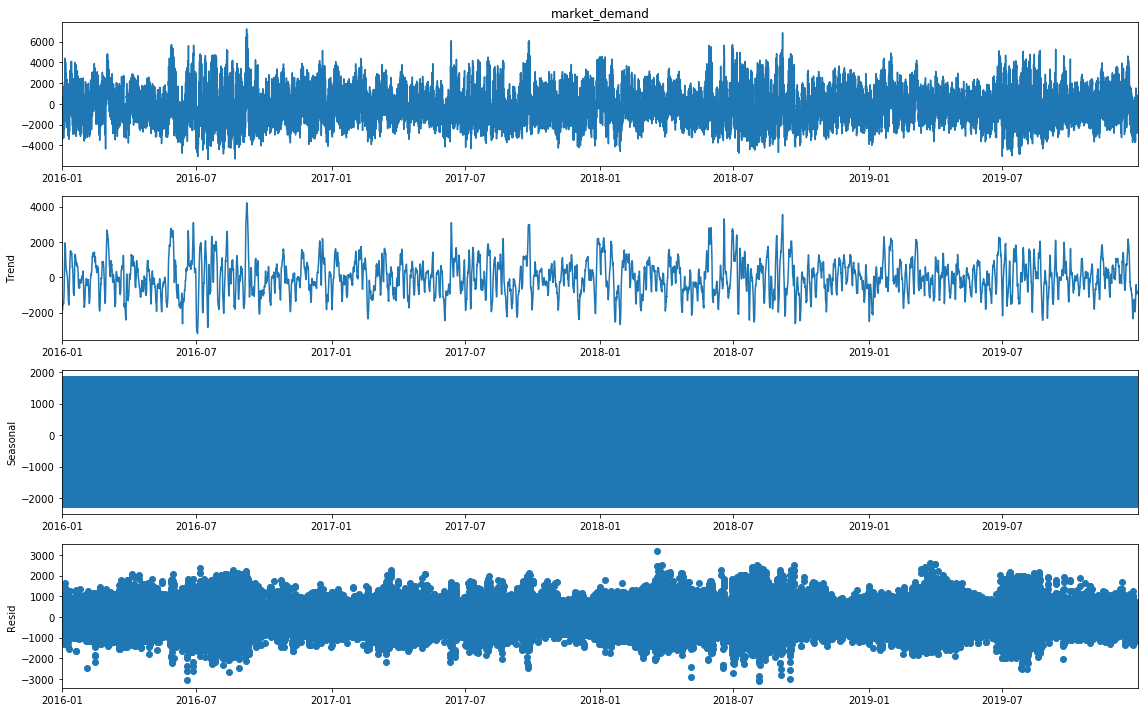

In [1013]:
decomposition = sm.tsa.seasonal_decompose(weather_ieso_df.market_demand) 
fig = decomposition.plot()
plt.show()

In [1023]:
decomposition.resid.bfill().ffill()

date_time
2016-01-01 00:00:00   -163.711359
2016-01-01 01:00:00   -163.711359
2016-01-01 02:00:00   -163.711359
2016-01-01 03:00:00   -163.711359
2016-01-01 04:00:00   -163.711359
                          ...    
2019-12-31 19:00:00    671.295942
2019-12-31 20:00:00    671.295942
2019-12-31 21:00:00    671.295942
2019-12-31 22:00:00    671.295942
2019-12-31 23:00:00    671.295942
Name: resid, Length: 35064, dtype: float64

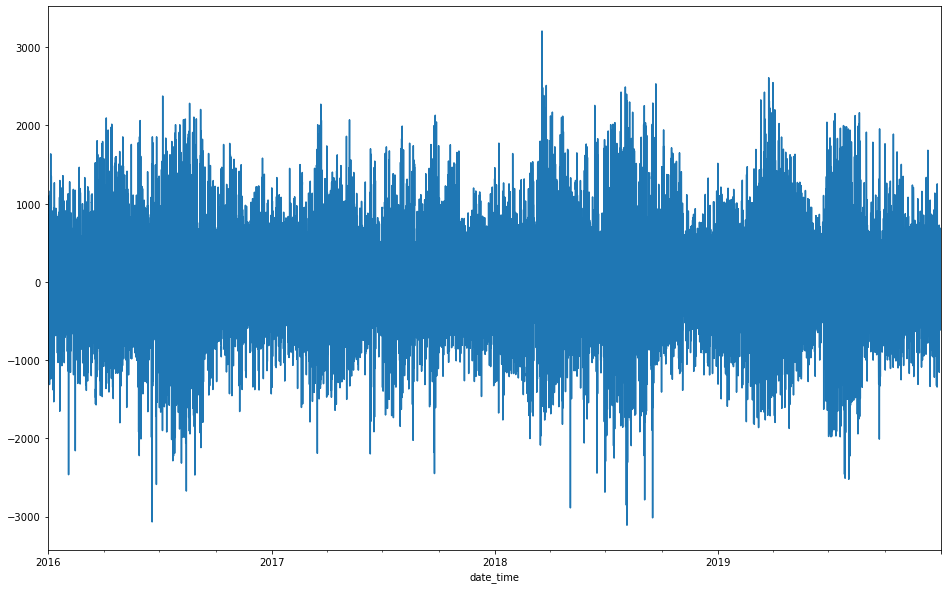

In [1025]:
decomposition.resid.bfill().ffill().plot()

#### LSTM

In [1012]:
def lstm_model(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = Sequential()
    model.add(LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(LSTM(int(cells/2), activation='relu'))
    model.add(Dense(n_hours))
    
    #define the learning rate
    optimizer = Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

In [ ]:
# train SARIMA model and get validation set performance
def get_sarima_mae(y_tr, hp, y_te):
    try:
        model = SARIMAX(y_tr, order=(hp[0],hp[1],hp[2]), seasonal_order=(hp[3],hp[4],hp[5],12)).fit()
        y_hat = model.get_forecast(steps=len(y_te)).predicted_mean
        return np.mean(np.abs(y_hat - y_te))
    except:
        return None

# define potential SARIMA hyperparameters
p = d = q = P = D = Q = range(2)
hp_list = list(product(p,d,q,P,D,Q))
grid_search = pd.DataFrame(columns=['p','d','q','P','D','Q','mae'])

# perform grid search
for i, hp in enumerate(hp_list):
    mae = get_sarima_mae(train, hp, validate)
    if mae != None:
        params = {'p':hp[0], 'd':hp[1], 'q':hp[2], 'P':hp[3], 'D':hp[4], 'Q':hp[5], 'mae':mae}
        grid_search = grid_search.append(params, ignore_index=True)

# display best performing hyperparamters
grid_search.sort_values('mae').head(1)

In [1342]:


# from datetime import datetime

# def is_dst(dt=None, timezone="UTC"):
#     if dt is None:
#         dt = datetime.utcnow()
#     timezone = pytz.timezone(timezone)
#     timezone_aware_date = timezone.localize(dt, is_dst=False)
#     return timezone_aware_date.tzinfo._dst.seconds != 0
# to_series().apply(is_dst, timezone="America/Toronto")
# dat.index.to_series().apply(is_dst, timezone="America/Toronto")

In [1343]:
is_dst(datetime(2019, 1, 1), timezone="US/Pacific")

False

In [1344]:
is_dst(datetime(2019, 3, 10, 2), timezone="US/Pacific")


False

In [1346]:
is_dst(datetime(2019, 11, 3, 1), timezone="America/Toronto")


False

In [1339]:
import pytz
for tz in pytz.all_timezones:
    if 'toronto' in tz.lower():
        print(tz)

America/Toronto


In [1332]:
dat = combined_csv.copy()
dat.date = pd.to_datetime(dat.date)

dat['hour'] = dat['hour'] - 1

dat['date_time'] = dat.apply(combine_date_time, axis = 1)


dat = dat.set_index('date_time')

dat = dat.drop(columns = ['ontario_demand', 'date', 'hour'])

In [1351]:
dst_dta = dat.index.to_series().apply(is_dst, timezone="America/Toronto")

In [1375]:
dst_dta[dst_dta.astype('uint8') ==1]

date_time
2002-05-01 00:00:00    True
2002-05-01 01:00:00    True
2002-05-01 02:00:00    True
2002-05-01 03:00:00    True
2002-05-01 04:00:00    True
                       ... 
2020-09-24 19:00:00    True
2020-09-24 20:00:00    True
2020-09-24 21:00:00    True
2020-09-24 22:00:00    True
2020-09-24 23:00:00    True
Name: date_time, Length: 103368, dtype: bool

In [1457]:
corr_df = drop_correlated_features(weather_ieso_df, 0.8)

In [1463]:
top_abs_correlations(corr_df, 20)

snow_9             snow_10               0.792035
Temp (°C)_1        Wind Chill_1          0.771818
Wind Spd (km/h)_6  Wind Spd (km/h)_9     0.770662
Rel Hum (%)_4      Rel Hum (%)_7         0.769020
Wind Spd (km/h)_1  Wind Spd (km/h)_9     0.756797
Rel Hum (%)_1      Rel Hum (%)_4         0.755818
Wind Spd (km/h)_7  Wind Spd (km/h)_9     0.743504
Wind Spd (km/h)_3  Wind Spd (km/h)_10    0.736142
Wind Spd (km/h)_4  Wind Spd (km/h)_10    0.730090
Rel Hum (%)_1      Rel Hum (%)_7         0.725764
Wind Chill_1       snow_9                0.719064
Wind Spd (km/h)_3  Wind Spd (km/h)_4     0.714962
Wind Chill_1       snow_10               0.709200
Wind Spd (km/h)_1  Wind Spd (km/h)_6     0.708781
Rel Hum (%)_4      Rel Hum (%)_8         0.708605
Rel Hum (%)_5      Rel Hum (%)_8         0.704853
Temp (°C)_1        snow_5                0.703282
                   snow_10               0.691051
                   snow_9                0.689515
Rel Hum (%)_1      Rel Hum (%)_5         0.689222


In [1465]:
corr_df.shape

(35064, 71)